In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from input_data import *
from NN_own import NN
from sklearn.model_selection import train_test_split


In [47]:
def mse(y, y_pred):
    return np.mean((y - y_pred)**2)

def r2_score(y, y_pred):
    y_mean = np.mean(y)
    ss_total = np.sum((y - y_mean)**2)
    ss_residual = np.sum((y - y_pred)**2)
    
    r2 = 1 - (ss_residual / ss_total)
    return r2

In [28]:
from activation_func import *
from cost_func import *

import activation_func
import cost_func
import numpy as np
class NN:
    def __init__(self,
                 X,
                 target,
                 n_neurons_list,
                 act_func_h,
                 classification = False):
        """
   Initialize a Neural Network.

   Parameters:
   - X (matrix): Input data.
   - n_neurons_list (list): List containing the number of neurons in each hidden and outpout layer.
   - act_func_h (str): Activation function for hidden layers. Accepted values: 'sigmoid', 'relu', etc.
   - act_func_o (str): Activation function for the output layer. Accepted values: 'sigmoid', 'softmax', etc.
   - output (bool): Type of output for the network ( 'classification' or 'regression'). Default false "regression".

        """
        self.X = X
        self.target = target
        self.n_samples = X.shape[0]
        self.n_features = X.shape[1]
        self.n_neurons_list = n_neurons_list
        self.layers = len(n_neurons_list)
        self.weights, self.biases = self.initialize_weights_and_biases()
        self.layer_outputs =[]
        self.probabilities = list()
        self.act_func_o = activation_func.identity
        self.d_act_func_o = activation_func.identity_d
        self.cost = mean_squared_error
        self.d_cost = mean_squared_error_gradient
        self.classification = classification
        
        
        
        
        if(act_func_h == "sigmoid"):
            self.act_func_h = activation_func.sigmoid
            self.d_act_func_h = activation_func.sigmoid_d
        elif(act_func_h == "relu"):
            self.act_func_h = activation_func.relu
            self.d_act_func_h= activation_func.relu_d
        elif(act_func_h == "leakyrelu"):
            self.act_func_h = activation_func.leakyrelu
            self.d_act_func_h = activation_func.leakyrelu_d
        elif(act_func_h == "elu"):
            self.act_function = activation_func.sigmoid
            self.d_act_func_h = activation_func.d_sigmoid
        else:
            print("please choose ,'sigmoid','relu','leakyrelu' or 'elu' \
                  as your activation function for ther hidden layers. Try again")
            quit()
        
 
        if self.classification:
            self.act_func_o = activation_func.sigmoid
            self.d_act_func_o = activation_func.sigmoid
            self.cost = binary_cross_entropy
            self.d_cost= binary_cross_entropy_gradient
        
        
        
        
        
    def initialize_weights_and_biases(self):
        """
        Initialize weights and biases for each layer in a neural network.

        """
        np.random.seed(0)
        n_layers = len(self.n_neurons_list)
        n_neurons = [self.n_features] + self.n_neurons_list

        weights = [np.random.randn(n_neurons[i], n_neurons[i-1]) for i in range(1, n_layers + 1)]
        biases = [np.random.randn(n_neurons[i], 1) for i in range(1, n_layers + 1)]

        return weights, biases
    
    def batch_generator(self,X, y, batch_size, shuffle=True):
        """
        Generate batches from input data X and target data y.

        Parameters:
        - X (numpy.ndarray): Input data matrix of shape (n, m), where n is the number of samples and m is the number of features.
        - y (numpy.ndarray): Target data vector of shape (n,).
        - batch_size (int): Size of each batch.
        - shuffle (bool): Whether to shuffle the input data before generating batches. Default is True.

        Yields:
        - X_batch (numpy.ndarray): Batch of input data of shape (batch_size, m).
        - y_batch (numpy.ndarray): Batch of target data of shape (batch_size,).
        """
        np.random.seed(0)
        n = X.shape[0]
        indices = np.arange(n)

        if shuffle:
            np.random.shuffle(indices)

        num_batches = n // batch_size
    
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            batch_indices = indices[start_idx:end_idx]
            
            X_batch = X[batch_indices, :]
            y_batch = y[batch_indices]
          
            yield X_batch, y_batch

        # If there's a remainder, yield the last batch
        if n % batch_size != 0:
            
            start_idx = num_batches * batch_size
            batch_indices = indices[start_idx:]

            X_batch = X[batch_indices, :]
            y_batch = y[batch_indices]

            yield X_batch, y_batch
    
    def clip_gradients(self,gradients, clip_value):
        """
        Clip gradients to prevent the exploding gradient problem.
    
        Parameters:
        - gradients: List or array of gradients.
        - clip_value: Threshold for clipping.
    
        Returns:
        - clipped_gradients: List of clipped gradients.
        """
        grad_norm = np.sqrt(sum(np.sum(g**2) for g in gradients))
        scale = clip_value / grad_norm if grad_norm > clip_value else 1.0
        clipped_gradients = [g * scale for g in gradients]

        return clipped_gradients
    
    
    def forward_pass(self, X, training = False):
        """
        Performs a forward pass through the NN.

        Parameters:
        - X (numpy.ndarray): Input data of shape (n_samples, n_features).
        - Training (boolean): defines if the forward pass is used for training. Defalut is False.

        Returns:
        - output (numpy.ndarray): Output of the network.
        """
        
        layer_output = X
        
        layer_outputs =[layer_output]
        
        # forward pass through hidden layers
        for i in range(len(self.weights) - 1):
            # Perform matrix multiplication
            
            weighted_input = layer_output @ self.weights[i].T 
            layer_input = weighted_input  + self.biases[i].T
            layer_output = self.act_func_h(layer_input)
            layer_outputs.append(layer_output)
        #forward pass through output layer
        
        output_layer_input = layer_output @ self.weights[-1].T + self.biases[-1].T
        output = self.act_func_o(output_layer_input)
        
        layer_outputs.append(output)
        
        if training:
        # Store the layer outputs in memory after each forward pass, if the network is training
            self.layer_outputs.append(layer_outputs)
        
        return output
    
    def backward_pass(self, X, target, lmb, clip_value=None):
        
        self.lmb = lmb
        # Retrieve stored layer outputs from the forward pass
        layer_outputs = self.layer_outputs.pop()
      
        delta = self.d_cost(layer_outputs[-1], target)
      
        # Gradient Clipping
        if clip_value is not None:
            gradients = [layer_outputs[-1].T @ delta, np.sum(delta, axis=0, keepdims=True)]
            gradients = self.clip_gradients(gradients, clip_value=clip_value)
      
            dweights = gradients[0]
            dbiases = gradients[1]
        else:
            dweights = layer_outputs[-1].T @ delta
            dbiases = np.sum(delta, axis=0, keepdims=True)

        if self.lmb > 0.0:
            dweights = dweights + self.lmb * self.weights[-1]

        # Update output layer parameters GD
        self.weights[-1] -= self.learning_rate * dweights
        self.biases[-1] -= self.learning_rate * dbiases.reshape(-1, 1)
      
        for i in range(len(self.weights) - 2, 0, -1):
            
            delta = delta @ self.weights[i + 1] * self.d_act_func_h(layer_outputs[i])

            # Calculate gradients for hidden layers
            if clip_value is not None:
                gradients = [layer_outputs[i].T @ delta, np.sum(delta, axis=0, keepdims=True)]
                gradients = self.clip_gradients(gradients, clip_value=clip_value)
          
                dweights = gradients[0]
                dbiases = gradients[1]
            else:
                dweights = layer_outputs[i].T @ delta
                dbiases = np.sum(delta, axis=0, keepdims=True)

            if self.lmb > 0.0:
                dweights = dweights + self.lmb * self.weights[i]

        # Update hidden layer parameters GD
        self.weights[i] -= self.learning_rate * dweights
        self.biases[i] -= self.learning_rate * dbiases.reshape(-1, 1)

        # Update input layer parameters GD
        delta = delta @ self.weights[1]
      
        if clip_value is not None:
            
            gradients = [layer_outputs[0].T @ delta, np.sum(delta, axis=0, keepdims=True)]
            gradients = self.clip_gradients(gradients, clip_value=clip_value)
      
            dweights = gradients[0]
            dbiases = gradients[1]
            
        else:
            
            dweights = layer_outputs[0].T @ delta
            dbiases = np.sum(delta, axis=0, keepdims=True)

        if self.lmb > 0.0:
            dweights = dweights + self.lmb * self.weights[0].T
        
        self.weights[0] -= self.learning_rate * dweights.T
        self.biases[0] -= self.learning_rate * dbiases.reshape(-1, 1)
    
    
    
    
    def train(self, epochs=1000, learning_rate=0.01, batch_size = 20, lmb = 0.1, clip_value = 0):
        """
       Trains the neural network using backpropagation.

       Parameters:
       - epochs (int, optional): Number of training epochs.
       - learning_rate (float, optional): Learning rate for weight updates.
       - batch_size (int, optional): Size of each training batch.
       - lmd (float, optional): Regularization parameter L1

       Returns:
       None
       """
        self.clip_value = clip_value
        self.lmb = lmb
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.errors = []
        total_error = 0
        
        for epoch in range(epochs):
            #X_batch, target_batch = self.batch_generator(self.X, self.target)
            batches = self.batch_generator(self.X, self.target, self.batch_size)
        
            
            for X_batch, target_batch in batches:
                output =self.forward_pass(X_batch, training=True)
                self.backward_pass(X_batch, self.learning_rate,lmb = self.lmb, clip_value=self.clip_value)
                
                # Calculate error using the cost function
                batch_error = self.cost(output, target_batch.reshape(-1))
                total_error += np.sum(batch_error)
            
            
                
            # Calculate average error for the epoch
            avg_error = total_error / self.n_samples
            self.errors.append(avg_error)
            total_error = 0
    
            # Print or log the error for monitoring
            #print(f"Epoch {epoch + 1}/{epochs}, Average Error: {avg_error}")
            
    def predict(self, X):
        """
       Make predictions using the trained neural network.

       Parameters:
       - X (numpy.ndarray): Input data for making predictions.

       Returns:
       numpy.ndarray: Predicted outputs.
       """
        output = self.forward_pass(X)
        if self.classification:
            for i in range(len(output)):
                if (output[i] < 0.5):
                    output[i] = int(0)
                elif (output[i]>= 0.5):
                    output[i] = int(1)
            return output.ravel()
        
        return output
 
    

In [29]:
np.random.seed(12)
# Create code
n = 40         # n x n number of data points
sigma2 = 0.01   # irreducible error
sigma = np.sqrt(sigma2)

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))

# create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# observed data
z = FrankeFunction(x, y) + noise

X = np.c_[x,y]

In [30]:
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state = 12)

# bytte variansen ut ifra data
# X_train_scaled = (X_train-np.mean(X_train))/
# X_test_scaled = (X_test-np.mean(X_train))/

# z_train_scaled=(z_train-np.mean(z_train))/sigma
# z_test_scaled=(z_test-np.mean(z_train))/sigma


# X_train, X_test, z_train, z_test = X_train_scaled, X_test_scaled, z_train_scaled,z_test_scaled

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

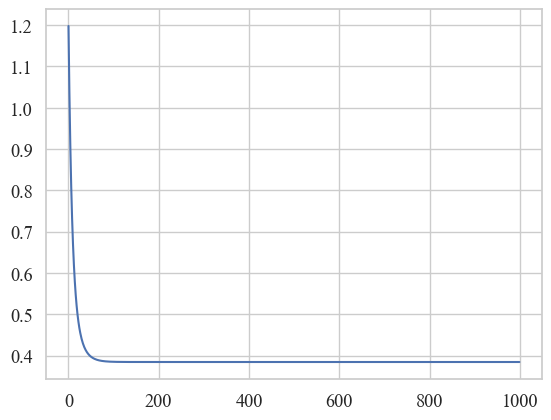

In [54]:
#Neural network
####################
neurons = [3,3,1]
eta = 0.1


# Create the neural network
model= NN(X_train,z_train,neurons, act_func_h = 'sigmoid')
model.train(batch_size = 20, lmb =0.1)


z_pred= model.predict(X_test)
#z_tilde = model.predict(X_train)
z_test.reshape(-1,1)

mse_trained = mean_squared_error(z_pred, z_test)
mse_test = mean_squared_error(z_pred,z_train)
#mse_train= (mse(X_test,z_tilde))

error = model.errors

plt.plot(np.arange(len(error)),error)
plt.plot(np.arange(len(X_train), z_tilde))

# Plotting in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting the true Franke function
ax.scatter(X_test[:, 0], X_test[:, 1], z_test, c='b', marker='o', label='True Franke Function')

# Plotting the predicted Franke function
ax.scatter(X_test[:, 0], X_test[:, 1], z_pred, c='r', marker='x', label='Predicted Franke Function')

ax.set_title('Comparison of True and Predicted Franke Function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')  # Assuming you have a third dimension, otherwise remove this line
ax.legend()


In [42]:
'''Calculating accuracies over different learning rates and L2 parameters'''

# Defining model parameters
etas = np.logspace(-6,-1,10)
l2_lambdas = np.logspace(-6,-1,10)
n_iterations = 100
costerror = np.zeros((len(etas), len(l2_lambdas)))
mse_test_list = np.zeros((len(etas), len(l2_lambdas)))
r2_test_list = np.zeros((len(etas), len(l2_lambdas)))

for i,eta in enumerate(etas):
    for j,lam in enumerate(l2_lambdas):
        model= NN(X_train,z_train,neurons, act_func_h = 'sigmoid')
        model.train(batch_size = 20, lmb = lam, learning_rate = eta, epochs = n_iterations)
        z_pred= model.predict(X_test)
        error = model.errors[-1]
        costerror[i,j] = error
        mse_test=mse(z_test, z_pred)
        r2_test =r2_score(z_test,z_pred)
        
        mse_test_list[i,j] =(mse_test)
        r2_test_list[i,j] = (r2_test)
        
        
        

In [33]:
# Creating a Dataframe with Accuracy-data and plotting a heatmap of the results

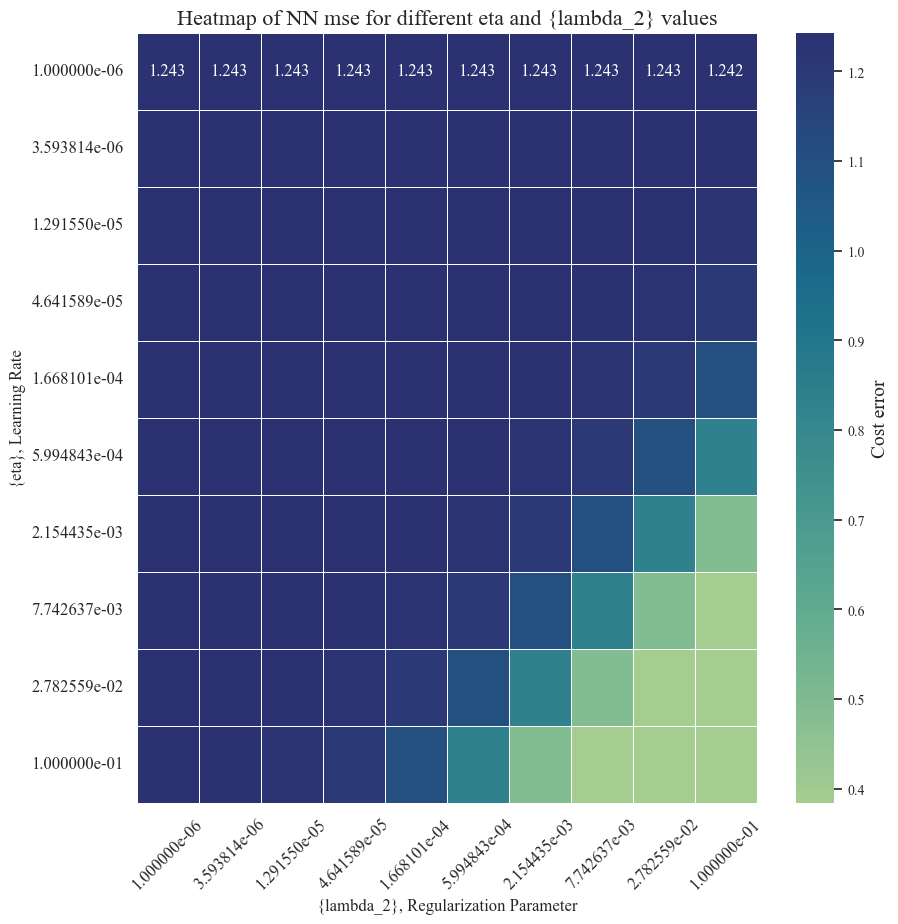

In [45]:


formatted_etas = ['{:e}'.format(i) for i in etas]
formatted_lmd = ['{:e}'.format(i) for i in l2_lambdas]

# Creating the dataframe
last_epoch_error = pd.DataFrame(costerror, index = formatted_etas, columns = formatted_lmd)

# Setting font-family for Matplotlib to "Times New Roman" to match Overleaf' s Latex font.
sns.set(font='Times New Roman', style='whitegrid', font_scale=1.2)

# Plot
title = "Heatmap of NN mse for different eta and {lambda_2} values"


# # Adjusting the figure size and annot font size
plt.figure(figsize=(10, 10))
ax = sns.heatmap(last_epoch_error, annot=True, cmap="crest",fmt=".3f", linewidths=0.5, annot_kws={"size": 12}, cbar_kws={'label': 'MSE for the last epoch'})

# Set x-axis and y-axis label font sizes
ax.set_xlabel("{lambda_2}, Regularization Parameter", fontsize=12)  # Add your X-axis label and adjust font size
ax.set_ylabel("{eta}, Learning Rate", fontsize=12)  # Add your Y-axis label and adjust font size


# Adjust x and y tick font size
ax.tick_params(axis='x', labelsize=12)  # Adjust x-axis tick font size
ax.tick_params(axis='y', labelsize=12)  # Adjust y-axis tick font size

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Rotate y-axis labels for better readability
plt.title(title, fontsize=16)

# Adjust colorbar font size
cax = ax.collections[0].colorbar.ax
cax.set_ylabel('Cost error', fontsize=14) 
cax.tick_params(labelsize=10)  # Adjust colorbar font size

plt.show()

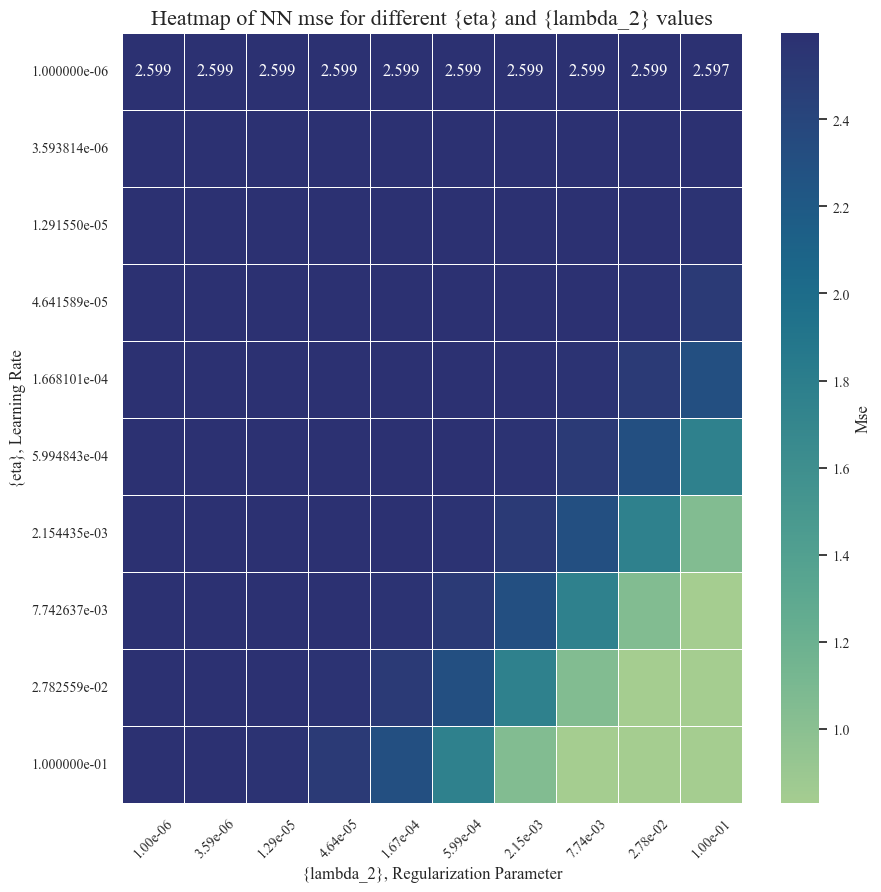

In [43]:
df_mse = pd.DataFrame(mse_test_list, index = formatted_etas, columns = formatted_lmd)

title = "Heatmap of NN mse for different {eta} and {lambda_2} values"


 # # Adjusting the figure size and annot font size
plt.figure(figsize=(10, 10))
ax = sns.heatmap(df_mse, annot=True, cmap="crest",fmt=".3f", linewidths=0.5, annot_kws={"size": 12}, cbar_kws={'label': 'MSE for the last epoch'})


 # Set x-axis and y-axis label font sizes
ax.set_xlabel("{lambda_2}, Regularization Parameter", fontsize=12)  # Add your X-axis label and adjust font size
ax.set_ylabel("{eta}, Learning Rate", fontsize=12)  # Add your Y-axis label and adjust font size


 # Adjust x and y tick font size
ax.tick_params(axis='x', labelsize=10)  # Adjust x-axis tick font size
ax.tick_params(axis='y', labelsize=10)  # Adjust y-axis tick font size

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Rotate y-axis labels for better readability
plt.title(title, fontsize=16)

# Adjust colorbar font size
cax = ax.collections[0].colorbar.ax
cax.set_ylabel('Mse', fontsize=12) 
cax.tick_params(labelsize=10)  # Adjust colorbar font size

plt.show()

# Checking the R2 score

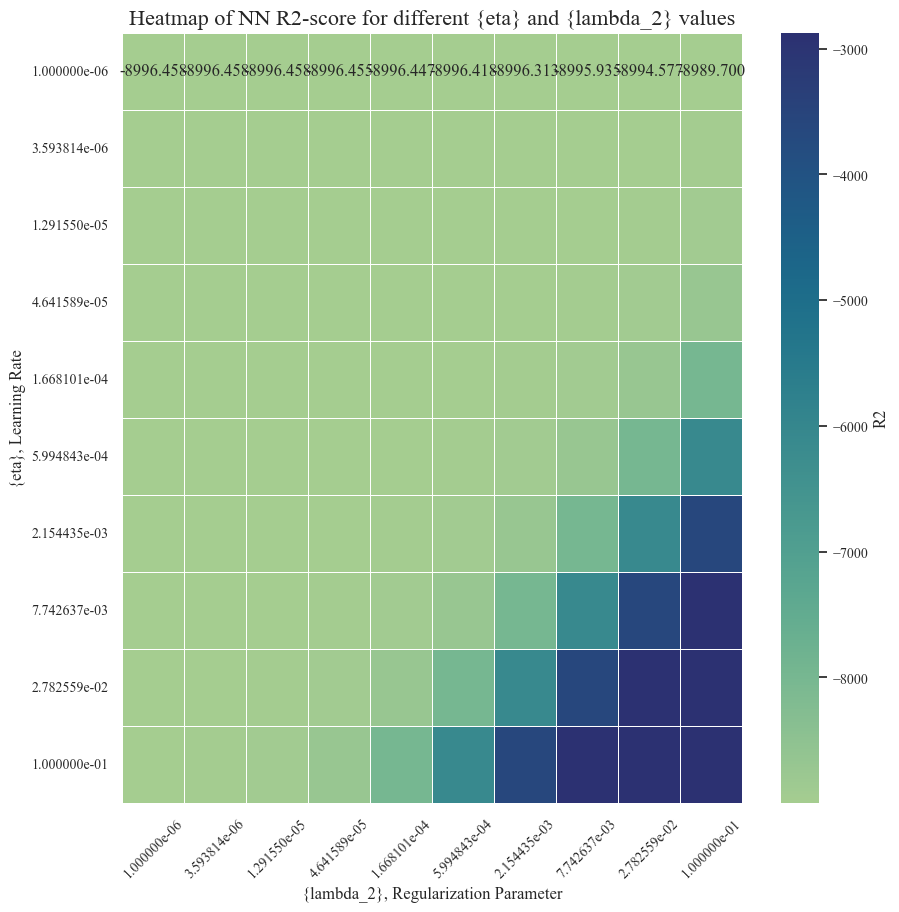

In [48]:
df_r2 = pd.DataFrame(r2_test_list, index = formatted_etas, columns = formatted_lmd)

title = "Heatmap of NN R2-score for different {eta} and {lambda_2} values"


 # # Adjusting the figure size and annot font size
plt.figure(figsize=(10, 10))
ax = sns.heatmap(df_r2, annot=True, cmap="crest",fmt=".3f", linewidths=0.5, annot_kws={"size": 12}, cbar_kws={'label': 'R2 score for the last epoch'})


 # Set x-axis and y-axis label font sizes
ax.set_xlabel("{lambda_2}, Regularization Parameter", fontsize=12)  # Add your X-axis label and adjust font size
ax.set_ylabel("{eta}, Learning Rate", fontsize=12)  # Add your Y-axis label and adjust font size


 # Adjust x and y tick font size
ax.tick_params(axis='x', labelsize=10)  # Adjust x-axis tick font size
ax.tick_params(axis='y', labelsize=10)  # Adjust y-axis tick font size

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Rotate y-axis labels for better readability
plt.title(title, fontsize=16)

# Adjust colorbar font size
cax = ax.collections[0].colorbar.ax
cax.set_ylabel('R2', fontsize=12) 
cax.tick_params(labelsize=10)  # Adjust colorbar font size

plt.show()

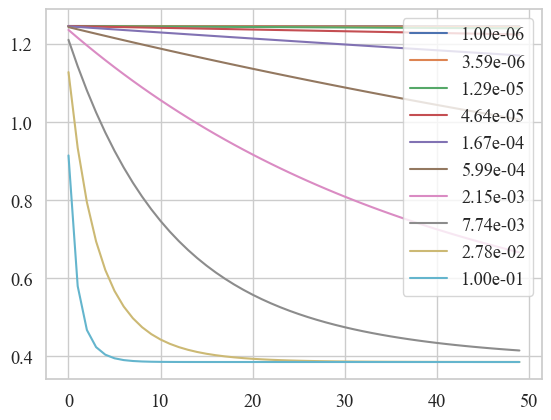

In [37]:
#Checking different lamdas for best eta found in previus heatmap.

eta = 0.1
etas = np.logspace(-6,-1,10)
l2_lambdas = np.logspace(-6,-1,10)
costerror = np.zeros(len(l2_lambdas))
formatted_lmd = ['{:.2e}'.format(i) for i in l2_lambdas]
for j,lam in enumerate(l2_lambdas):
    model= NN(X_train,z_train,neurons, act_func_h = 'sigmoid')
    model.train(batch_size = 20, lmb = lam, learning_rate = eta,epochs = 200)
    z_pred= model.predict(X_test)
    
    error = model.errors
    s = error[:200]
    # formatted_etas = ['{:e}'.format(i) for i in etas]
    labels = formatted_lmd[j]
    #costerror[j] = error
    plt.plot(np.arange(len(s[:50])),s[:50],label=labels)
    plt.legend(loc='upper right')
    
    

# Checking different act functions

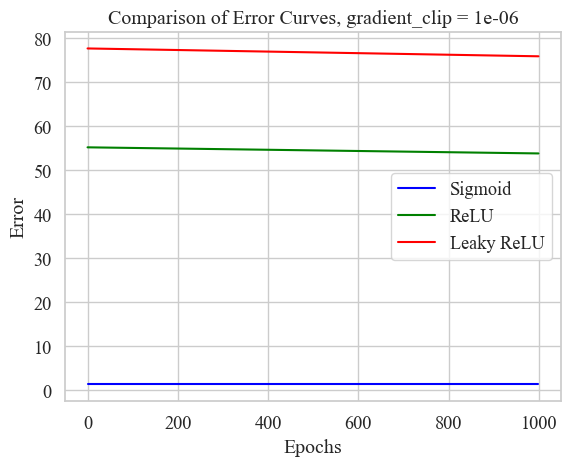

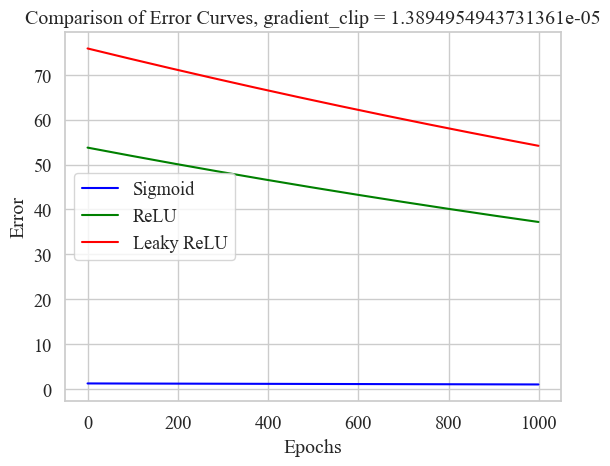

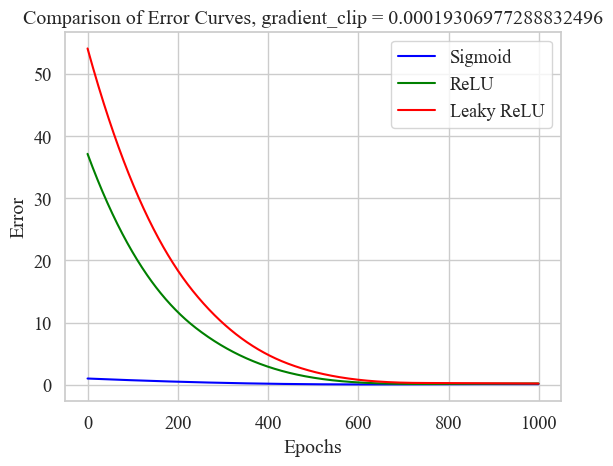

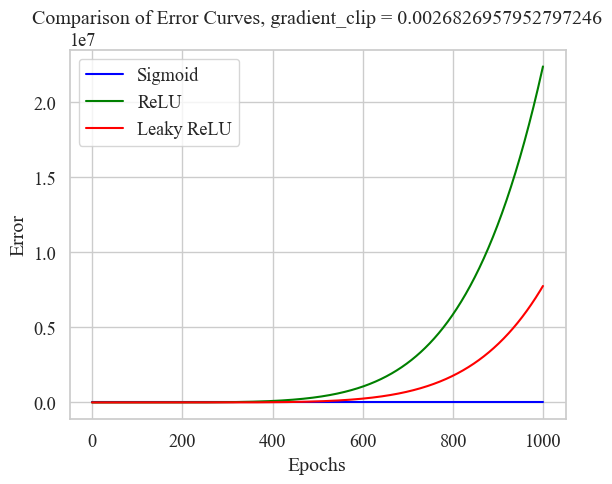

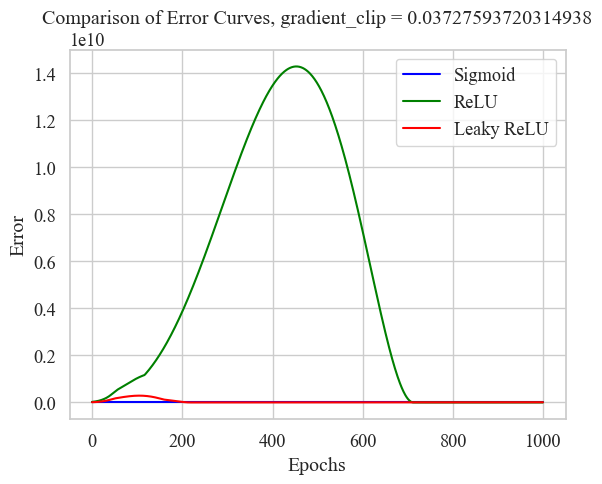

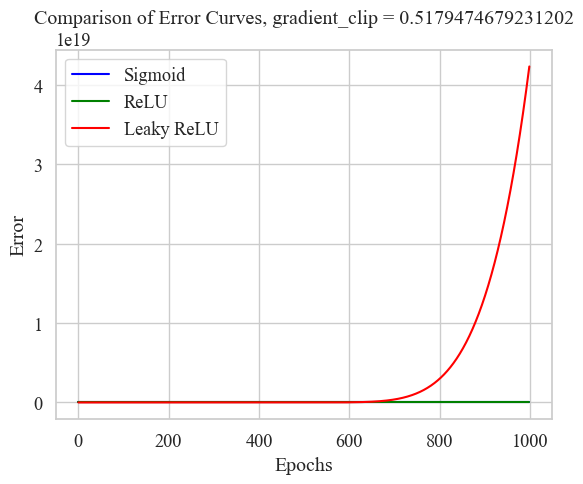

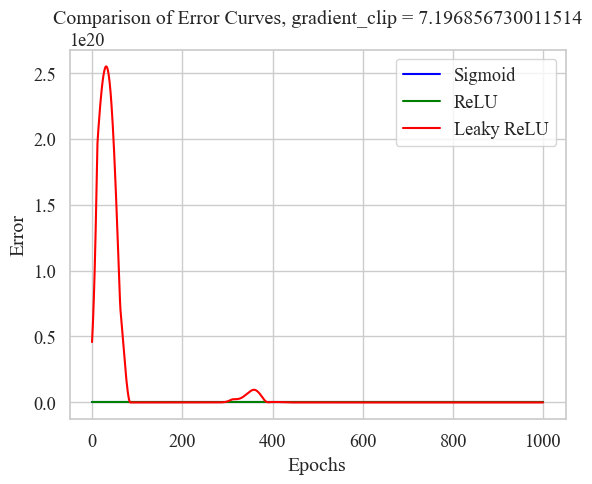

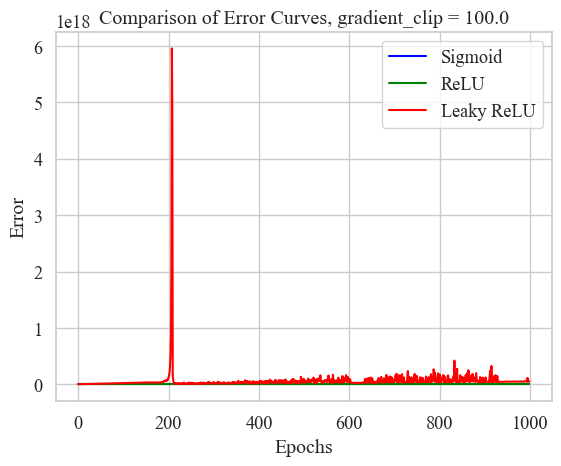

In [38]:

np.random.seed(12)
# Create code
n = 40         # n x n number of data points
sigma2 = 0.01   # irreducible error
sigma = np.sqrt(sigma2)

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))

# create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# observed data
z = FrankeFunction(x, y) + noise

x.ravel()
y.ravel()

X = np.c_[x,y]


X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state = 12)

neurons = [3,3,3,1]

model_sig= NN(X_train,z_train,neurons, act_func_h = 'sigmoid')
model_relu=NN(X_train,z_train,neurons, act_func_h = 'relu')
model_leakyrelu =NN(X_train,z_train,neurons, act_func_h = 'leakyrelu')

lam = 0
eta = 0.1
n_iterations = 1000

clip_values = np.logspace(-6, 2, 8)

mse_sig_list =[]
mse_relu_list =[]
mse_leakyrelu_list =[]
for clip_value in clip_values:
    
    model_sig.train(batch_size = 20, lmb = lam, learning_rate = eta, epochs = n_iterations, clip_value=clip_value)
    model_relu.train(batch_size = 20, lmb = lam, learning_rate = eta, epochs = n_iterations, clip_value=clip_value)
    model_leakyrelu.train(batch_size = 20, lmb = lam, learning_rate = eta, epochs = n_iterations, clip_value=clip_value)
    
    z_pred_sig= model_sig.predict(X_test)
    z_pred_relu=model_relu.predict(X_test)
    z_pred_leakyrelu=model_leakyrelu.predict(X_test)
    
    mse_sig = mse(z_test,z_pred_sig)
    mse_relu = mse(z_test,z_pred_relu)
    mse_leakyrelu = mse(z_test,z_pred_leakyrelu)
    
    mse_sig_list.append(mse_sig)
    mse_relu_list.append(mse_relu)
    mse_leakyrelu_list.append(mse_leakyrelu)
    
    error_sig = model_sig.errors
    error_relu = model_relu.errors
    error_leakyrelu = model_leakyrelu.errors
    
    fig, ax = plt.subplots()
    ax.plot(np.arange(len(error_sig)), error_sig, label='Sigmoid', color='blue')
    ax.plot(np.arange(len(error_relu)), error_relu, label='ReLU', color='green')
    ax.plot(np.arange(len(error_leakyrelu)), error_leakyrelu, label='Leaky ReLU', color='red')
    
    ax.set_title(f'Comparison of Error Curves, gradient_clip = {clip_value}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Error')
    ax.legend()
    
    plt.show()

df_mse = pd.DataFrame({'Key': clip_values, 'MSE_sig': mse_sig_list, 'MSE_relu': mse_relu_list, 'MSE_leakyrelu': mse_leakyrelu_list})

In [39]:
df_mse

,Key,MSE_sig,MSE_relu,MSE_leakyrelu
0,0.000001,2.564528,1.033440e+02,1.461697e+02
1,0.000014,2.101580,7.089329e+01,1.035052e+02
2,0.000193,0.168110,3.817912e-01,3.364432e-01
3,0.002683,0.165964,4.571089e+07,1.579709e+07
4,0.037276,0.165958,4.634468e+03,1.834092e+07
5,0.517947,0.165958,2.834148e+06,8.883601e+19
6,7.196857,0.165958,7.005171e+03,7.411318e+13
7,100.000000,0.165958,7.005171e+03,1.814699e+17


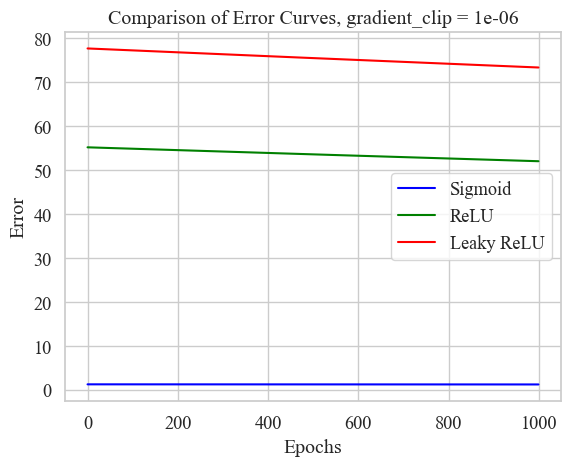

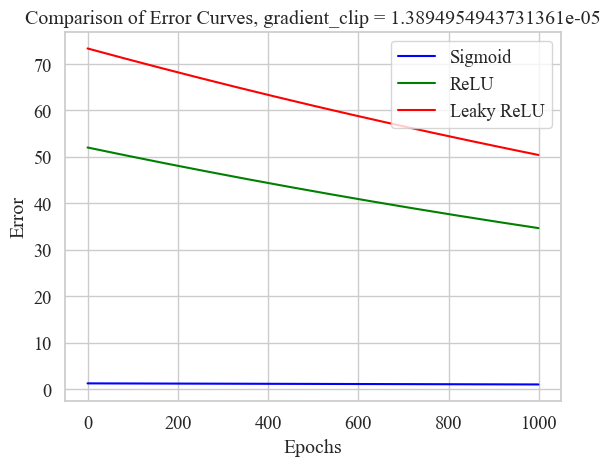

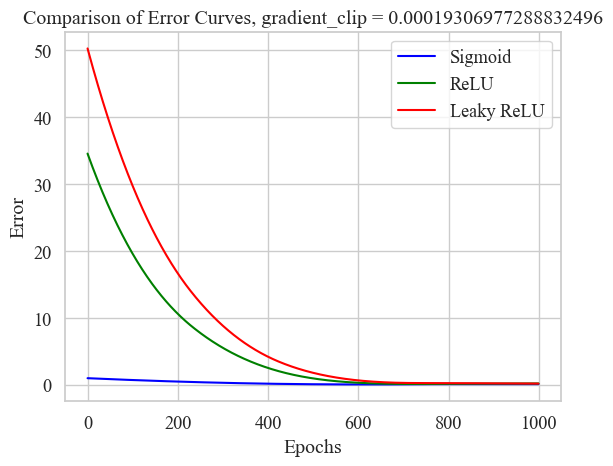

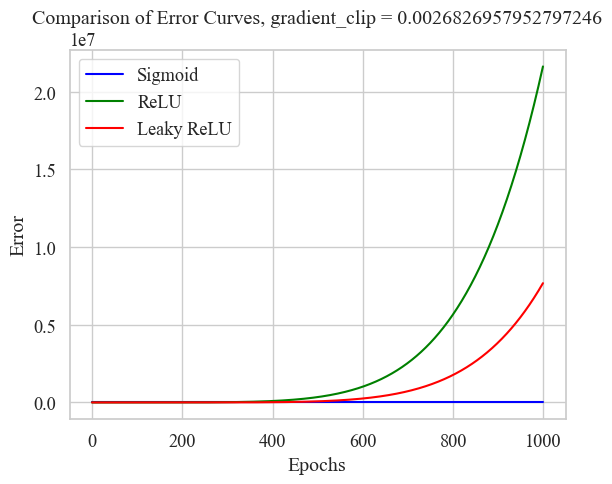

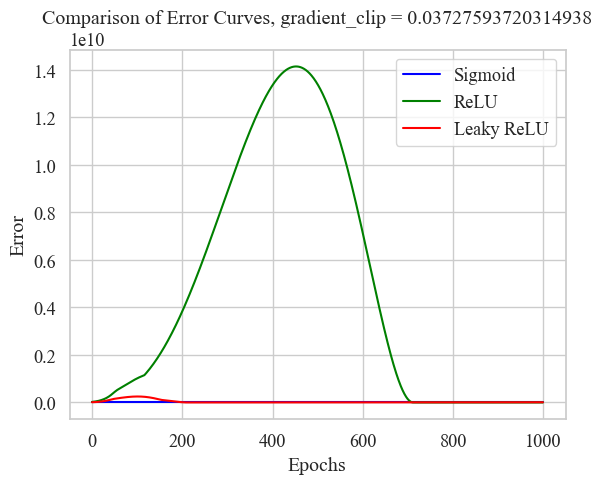

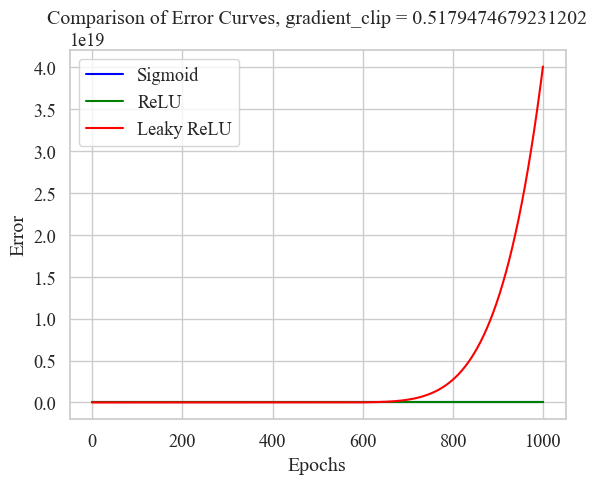

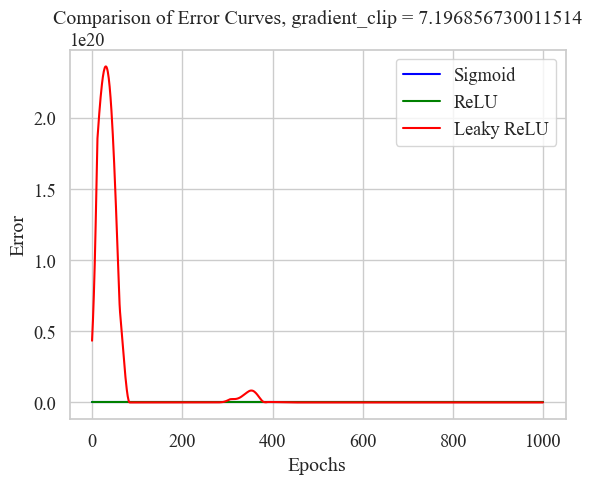

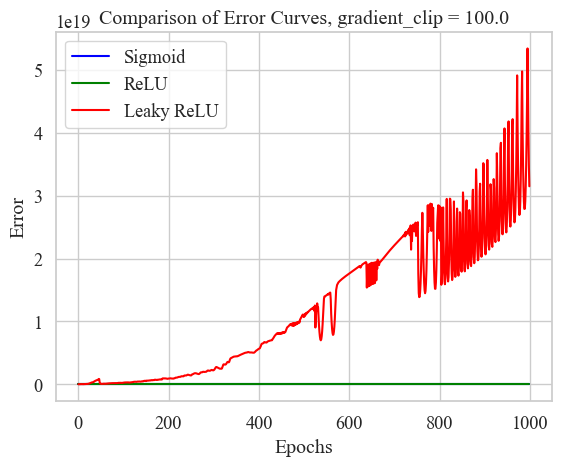

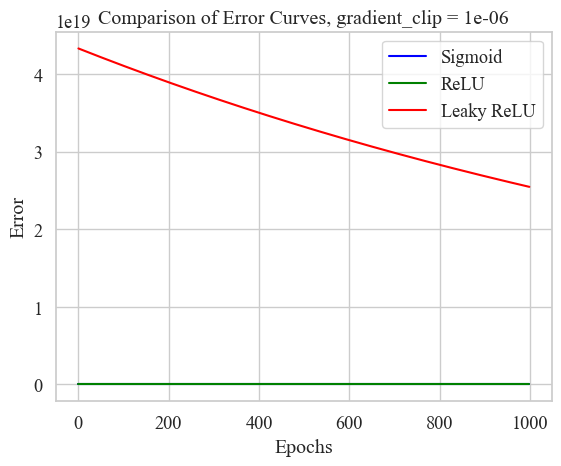

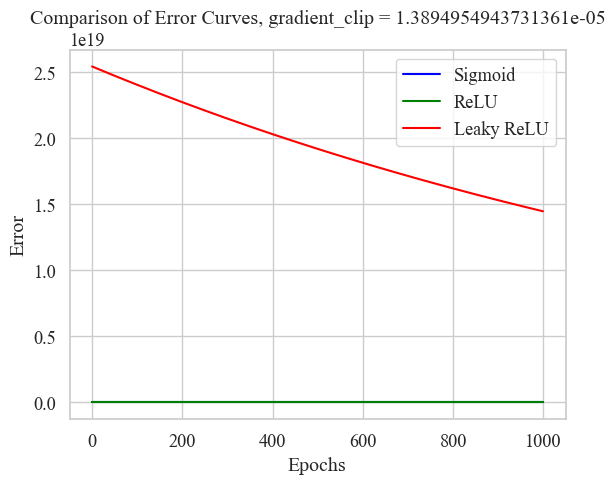

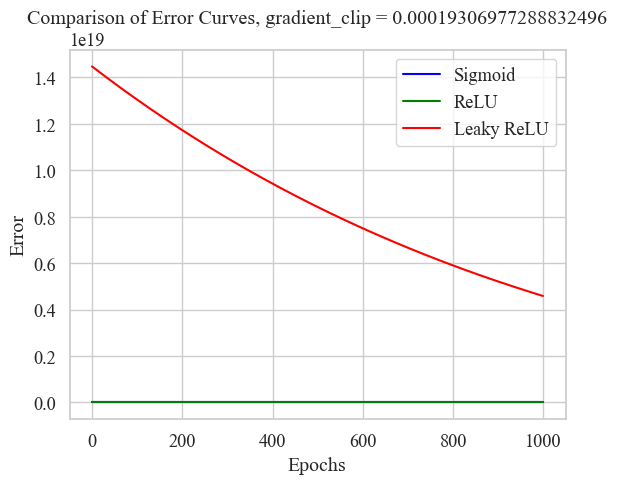

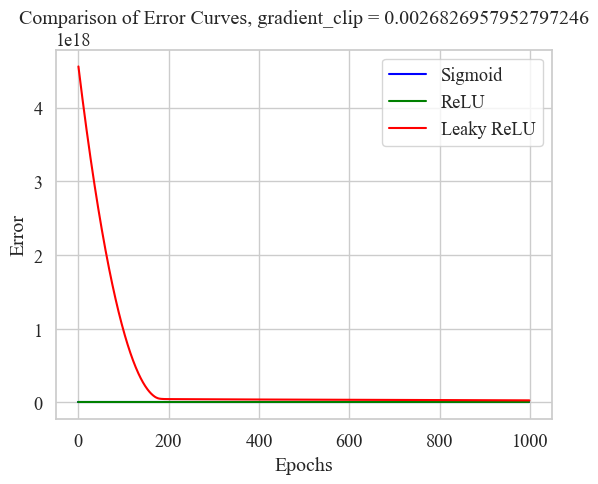

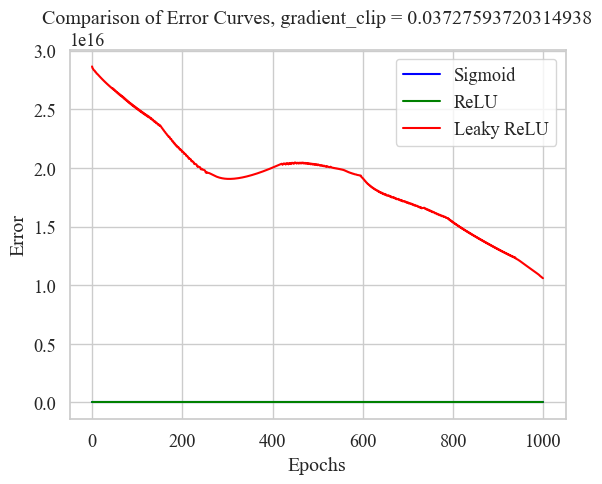

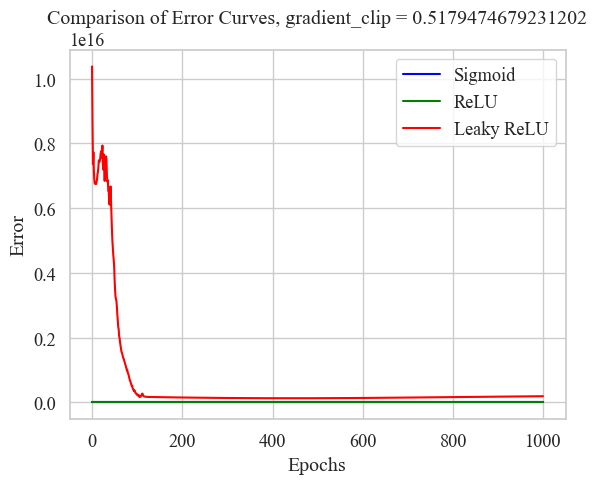

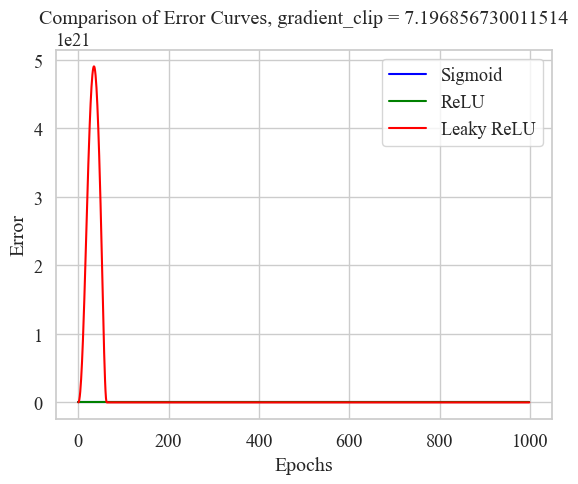

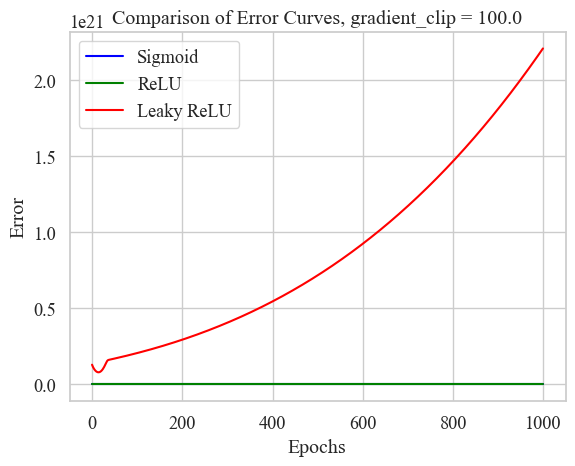

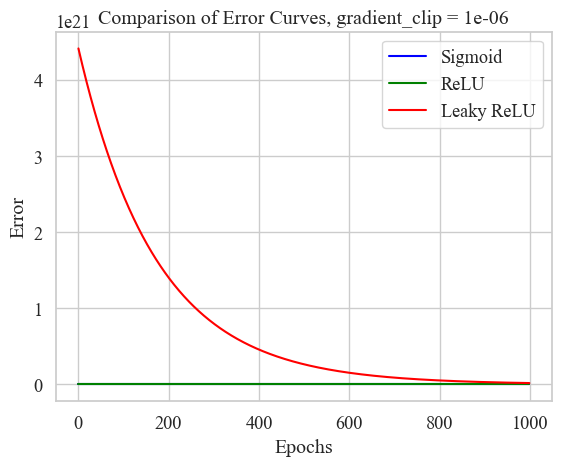

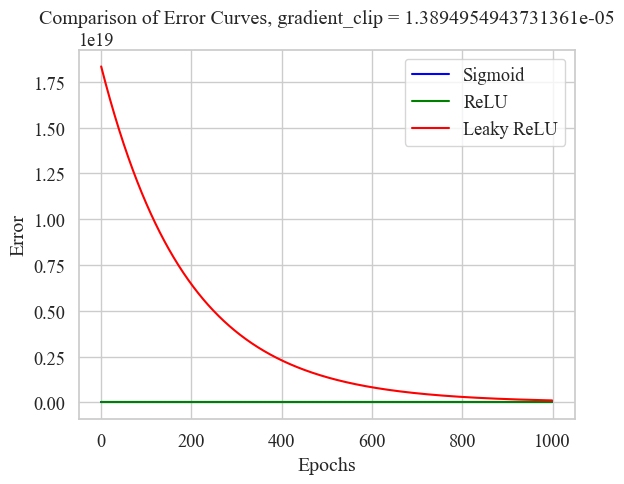

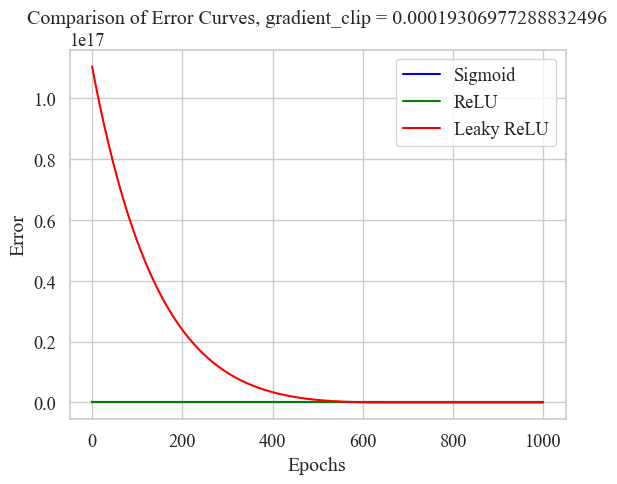

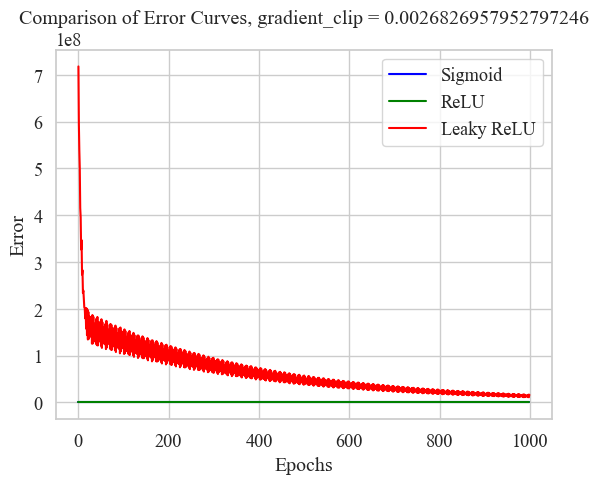

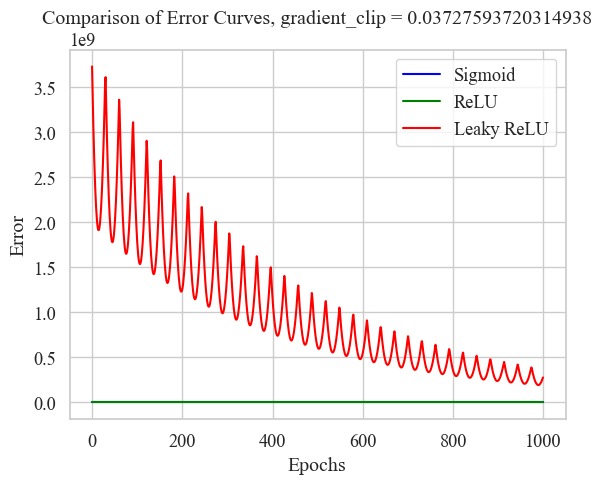

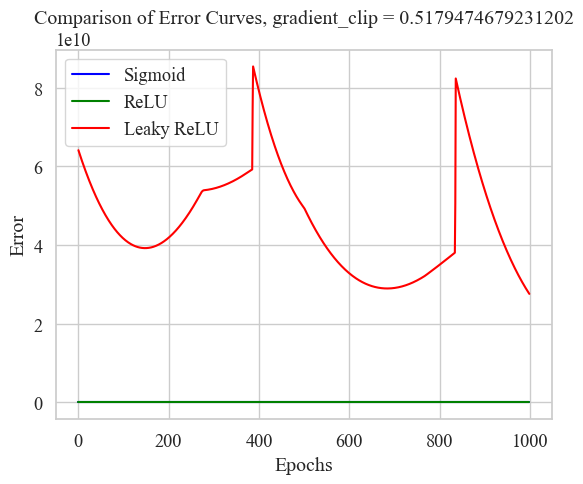

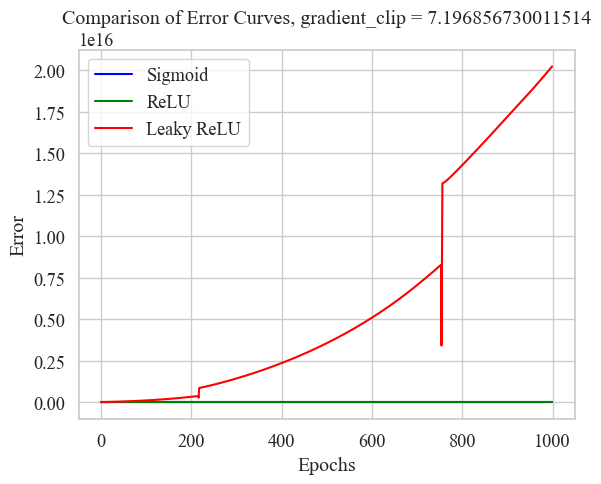

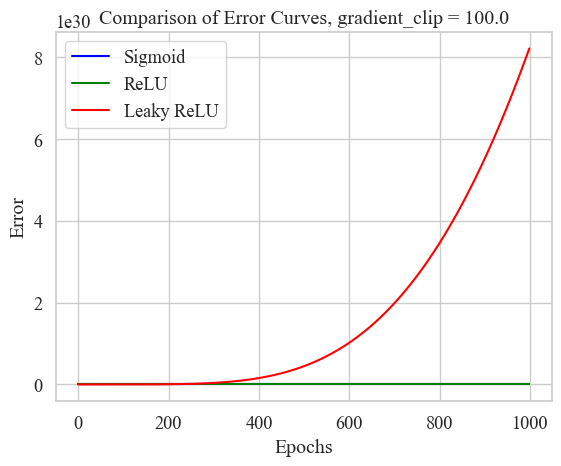

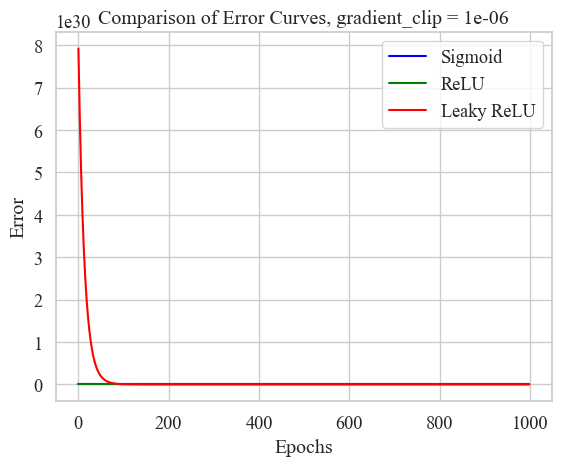

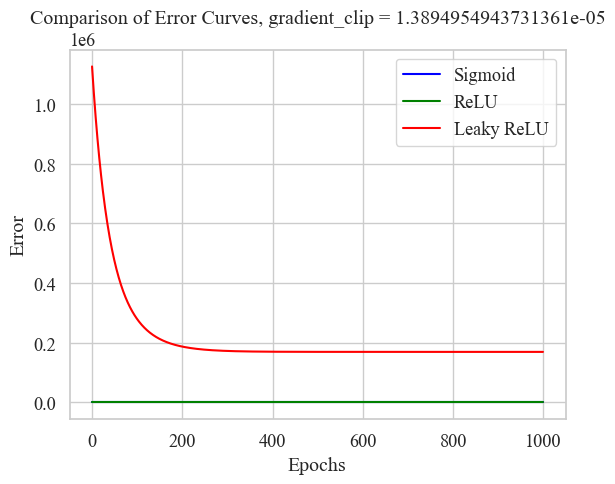

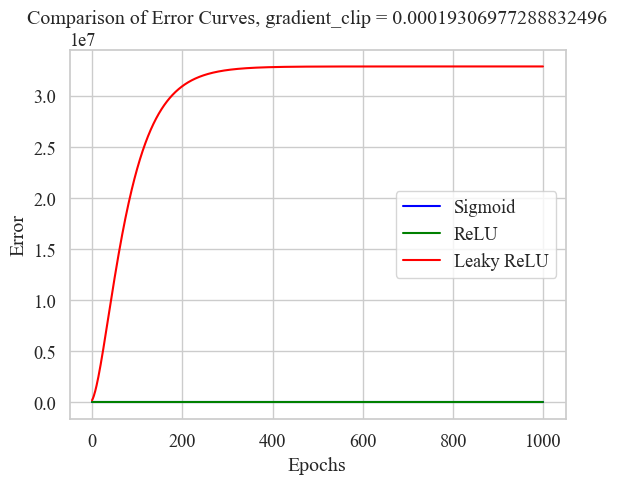

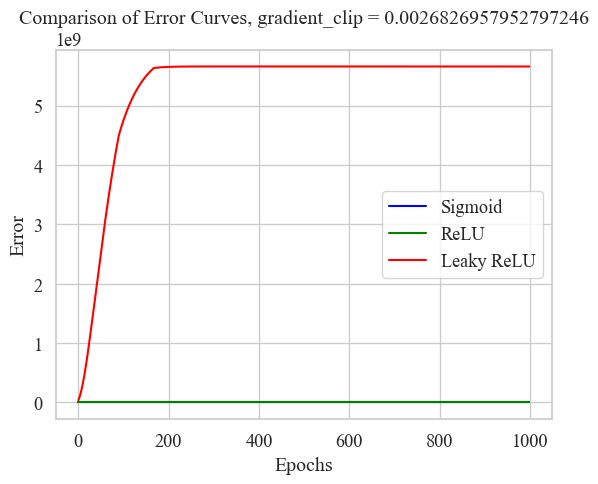

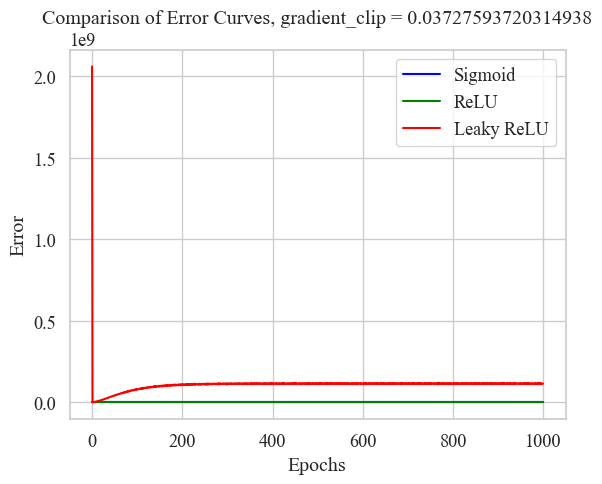

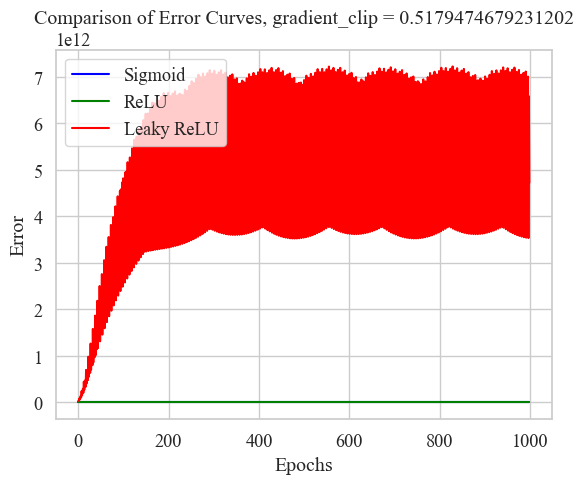

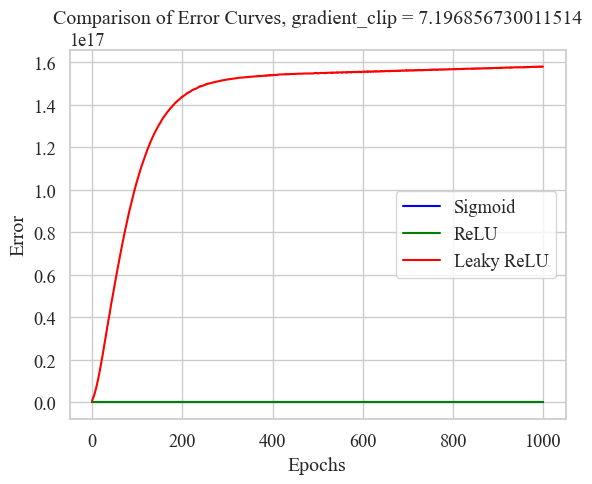

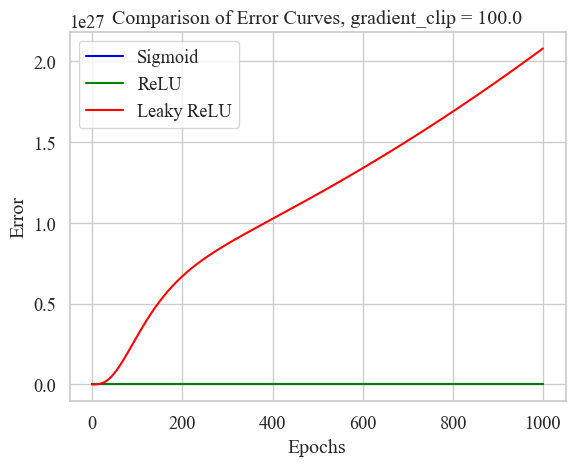

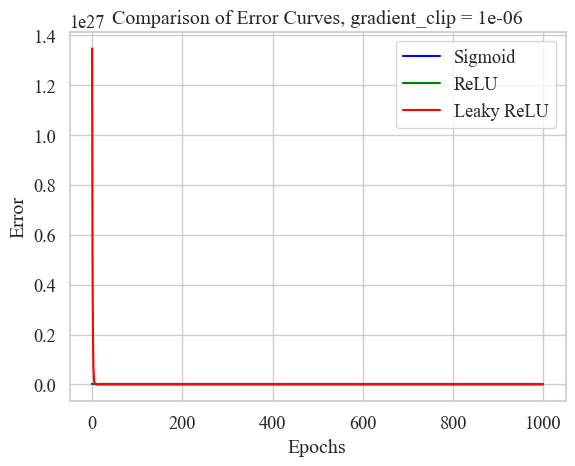

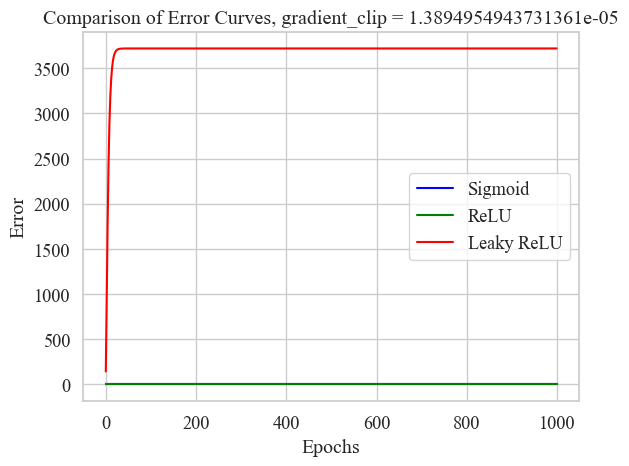

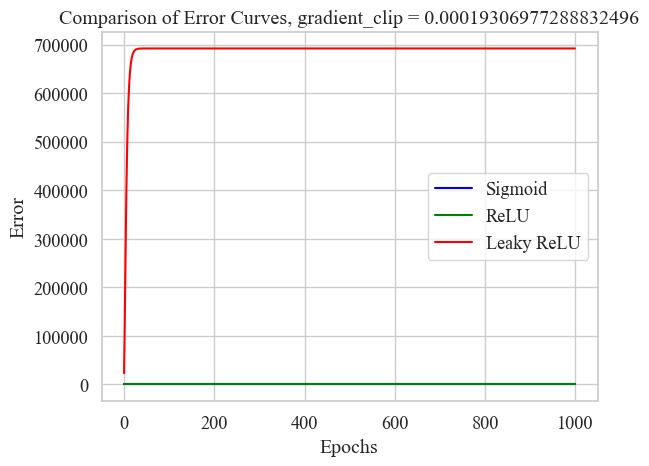

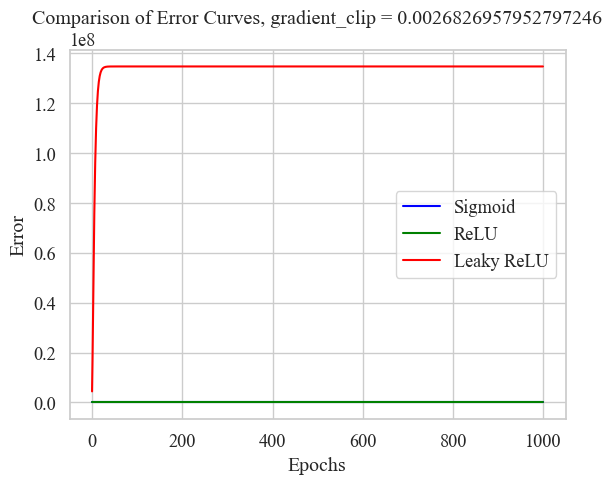

KeyboardInterrupt: 

In [55]:

model_sig= NN(X_train,z_train,neurons, act_func_h = 'sigmoid')
model_relu=NN(X_train,z_train,neurons, act_func_h = 'relu')
model_leakyrelu =NN(X_train,z_train,neurons, act_func_h = 'leakyrelu')


eta = 0.1
n_iterations = 1000

clip_values = np.logspace(-6, 2, 8)
lam = np.logspace(-6,2,8)

mse_sig_list =np.zeros((len(clip_values), len(lam)))
mse_relu_list =np.zeros((len(clip_values), len(lam)))
mse_leakyrelu_list =np.zeros((len(clip_values), len(lam)))

for i,lmd in enumerate(lam):
    for j, clip_value in enumerate(clip_values):

        model_sig.train(batch_size = 20, lmb = lmd, learning_rate = eta, epochs = n_iterations, clip_value=clip_value)
        model_relu.train(batch_size = 20, lmb = lmd, learning_rate = eta, epochs = n_iterations, clip_value=clip_value)
        model_leakyrelu.train(batch_size = 20, lmb = lmd, learning_rate = eta, epochs = n_iterations, clip_value=clip_value)

        z_pred_sig= model_sig.predict(X_test)
        z_pred_relu=model_relu.predict(X_test)
        z_pred_leakyrelu=model_leakyrelu.predict(X_test)

        mse_sig = mse(z_test,z_pred_sig)
        mse_relu = mse(z_test,z_pred_relu)
        mse_leakyrelu = mse(z_test,z_pred_leakyrelu)

        mse_sig_list[i,j] =mse_sig
        mse_relu_list[i,j] = mse_relu
        mse_leakyrelu_list[i,j] = mse_leakyrelu
        

        error_sig = model_sig.errors
        error_relu = model_relu.errors
        error_leakyrelu = model_leakyrelu.errors

        fig, ax = plt.subplots()
        ax.plot(np.arange(len(error_sig)), error_sig, label='Sigmoid', color='blue')
        ax.plot(np.arange(len(error_relu)), error_relu, label='ReLU', color='green')
        ax.plot(np.arange(len(error_leakyrelu)), error_leakyrelu, label='Leaky ReLU', color='red')

        ax.set_title(f'Comparison of Error Curves, gradient_clip = {clip_value}')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Error')
        ax.legend()

        plt.show()

df_mse = pd.DataFrame({'Key': clip_values, 'MSE_sig': mse_sig_list, 'MSE_relu': mse_relu_list, 'MSE_leakyrelu': mse_leakyrelu_list})